<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Graphs For Data Science</h1>
<h1>Graph Connectivity</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import os
import random

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm.notebook import tqdm

tqdm.pandas()

import networkx as nx

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 8.12.2

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: e43f8f2a12d1ccc6795925a8c2c7539dca8c1139

pandas    : 1.5.3
matplotlib: 3.7.1
tqdm      : 4.62.0
networkx  : 3.1
numpy     : 1.24.2
watermark : 2.1.0
json      : 2.0.9



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Example Network

In [4]:
G_test = nx.DiGraph()
G_test.add_edges_from([
    (0, 1),
    (0, 3),
    (1, 2),
    (1, 4),
    (2, 0),
    (2, 6),
    (3, 2),
    (4, 5),
    (4, 6),
    (5, 6),
    (5, 7),
    (5, 8),
    (5, 9),
    (6, 4),
    (7, 9),
    (8, 9),
    (9, 8),
    (10, 11),
    (11, 12),
    (12, 10),
    (11, 13),
    (11, 14),
    (11, 16),
    (13, 15),
    (14, 15)
])

/Users/bgoncalves/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/bgoncalves/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


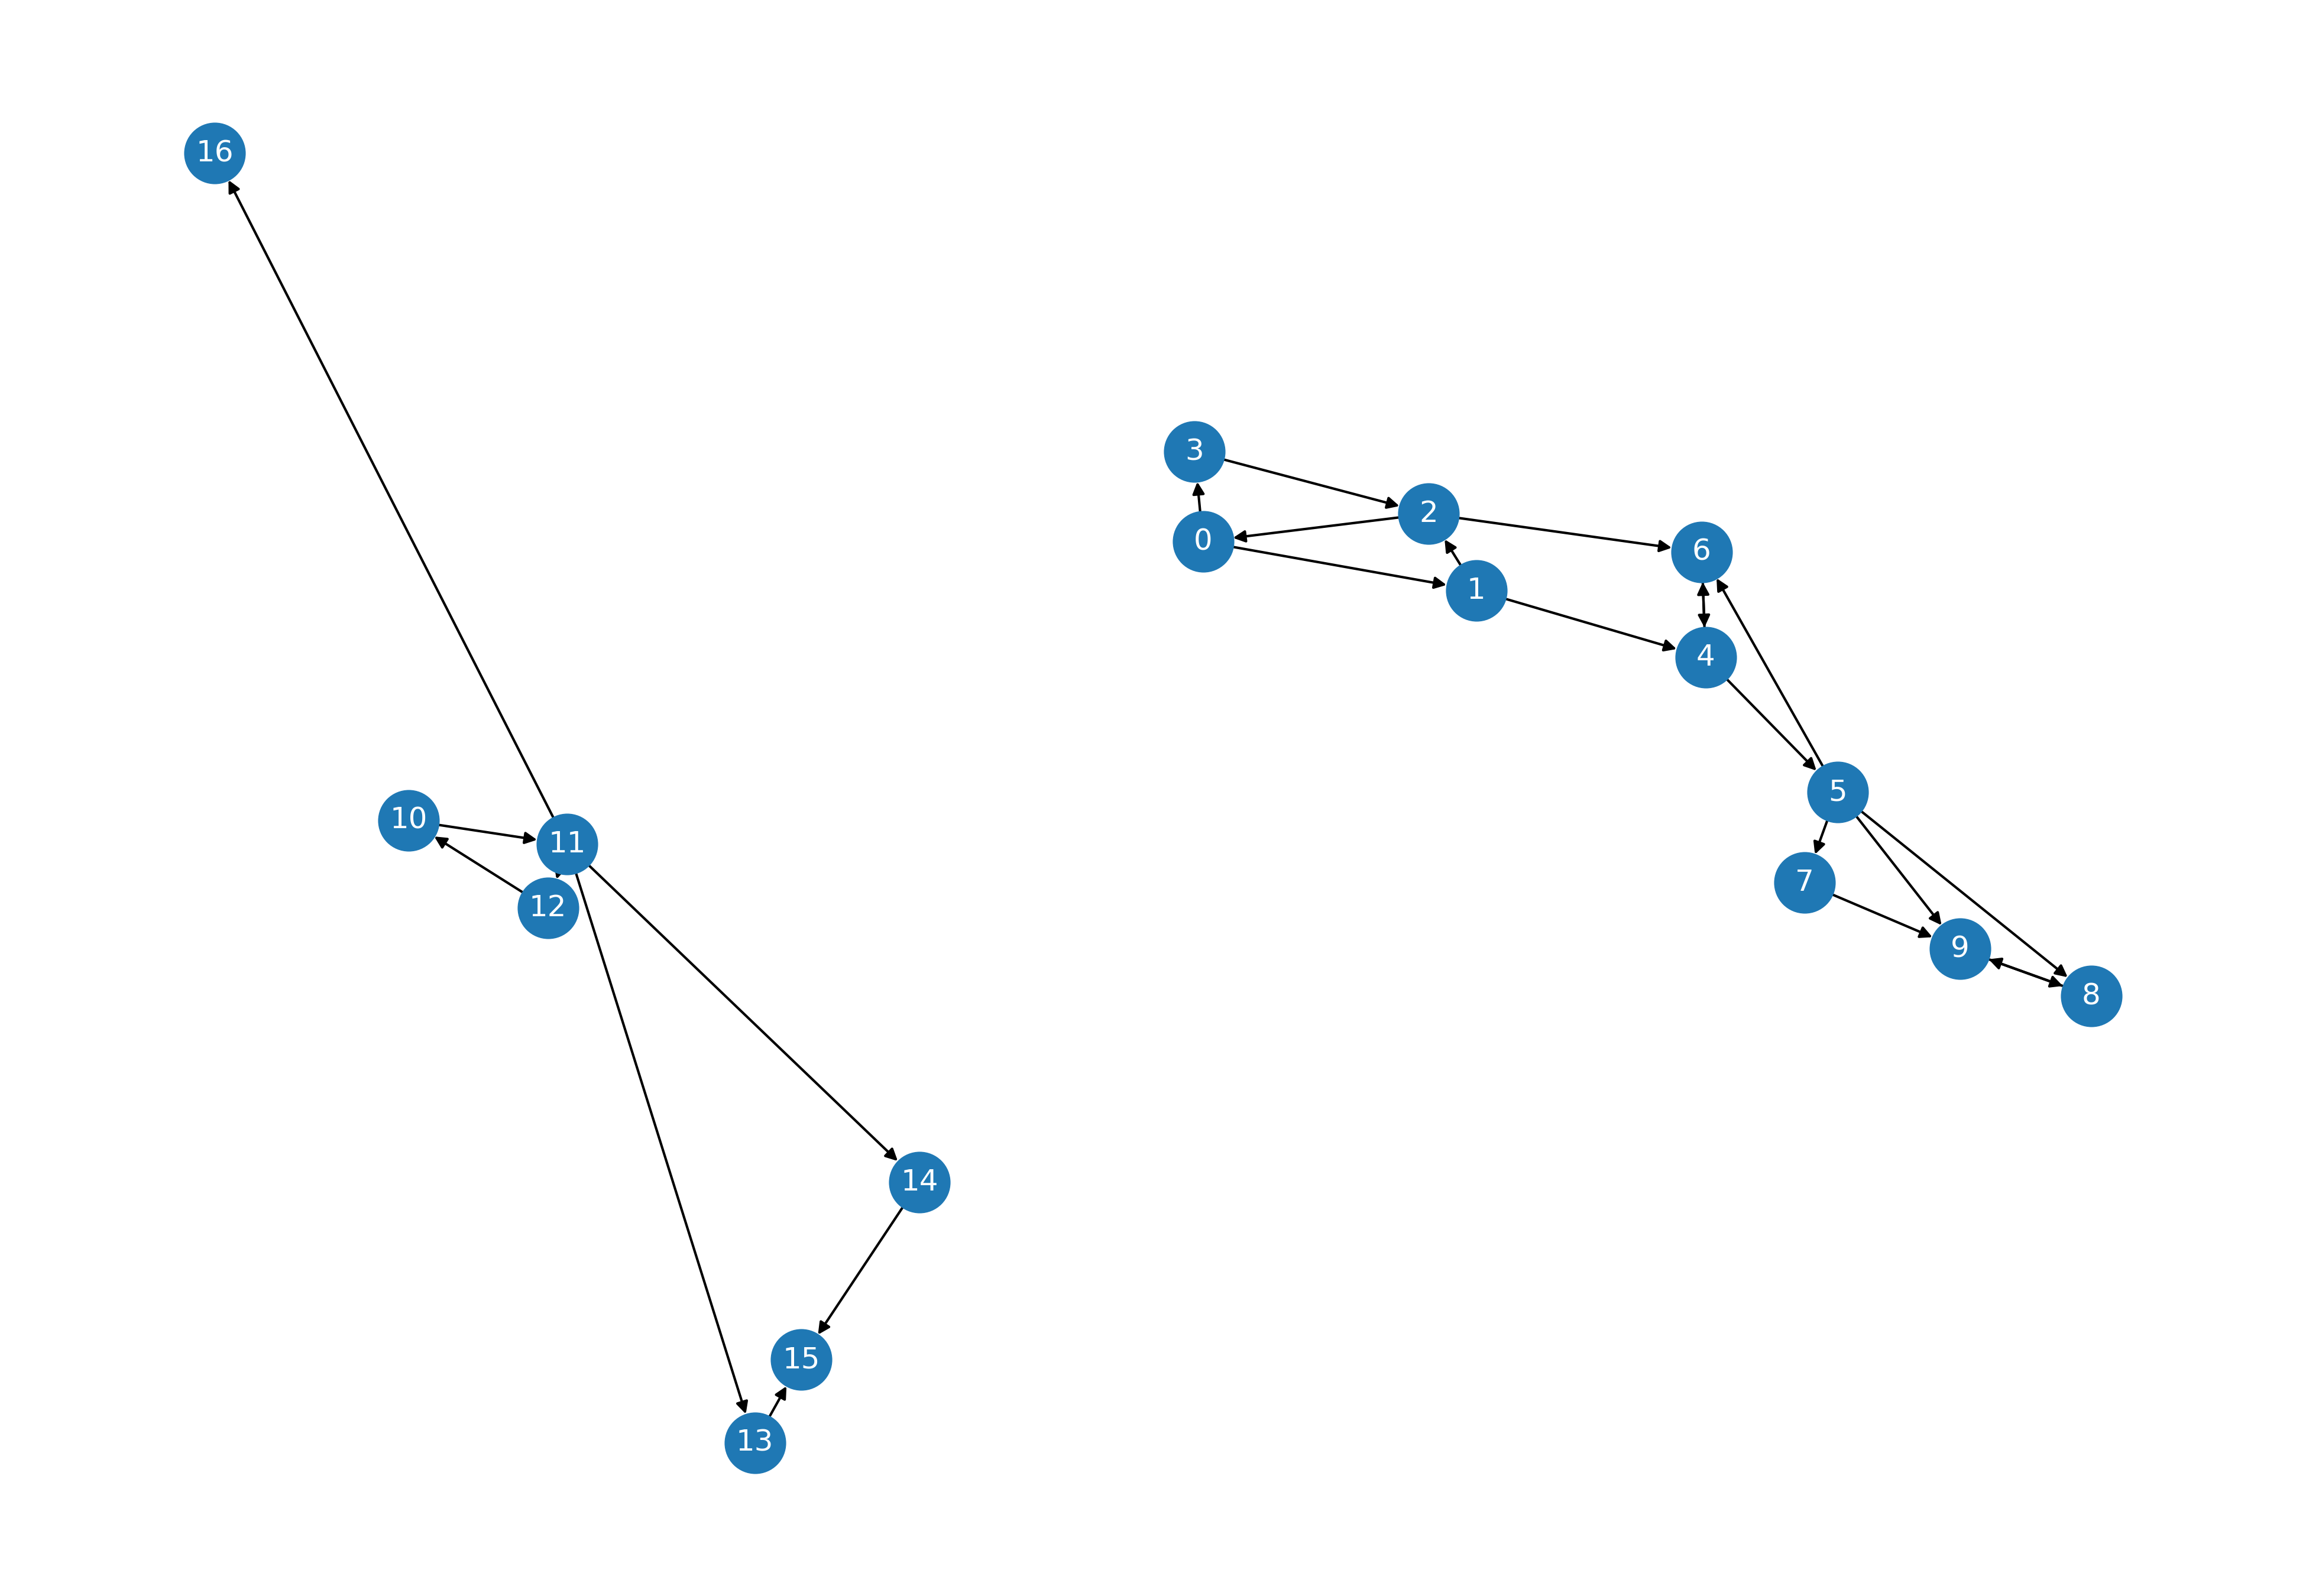

In [5]:
np.random.seed(1337)
random.seed(1337)
G_pos = nx.layout.fruchterman_reingold_layout(G_test)
nx.draw(G_test, pos=G_pos, node_size=600)
nx.draw_networkx_labels(G_test, pos=G_pos, font_color='white');

# Weakly Connected Components

We find 2 weakly connected components in our test network

In [7]:
WCC = list(nx.weakly_connected_components(G_test))
print(WCC)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, {10, 11, 12, 13, 14, 15, 16}]


A quick visualization can confirm that they are reasonable

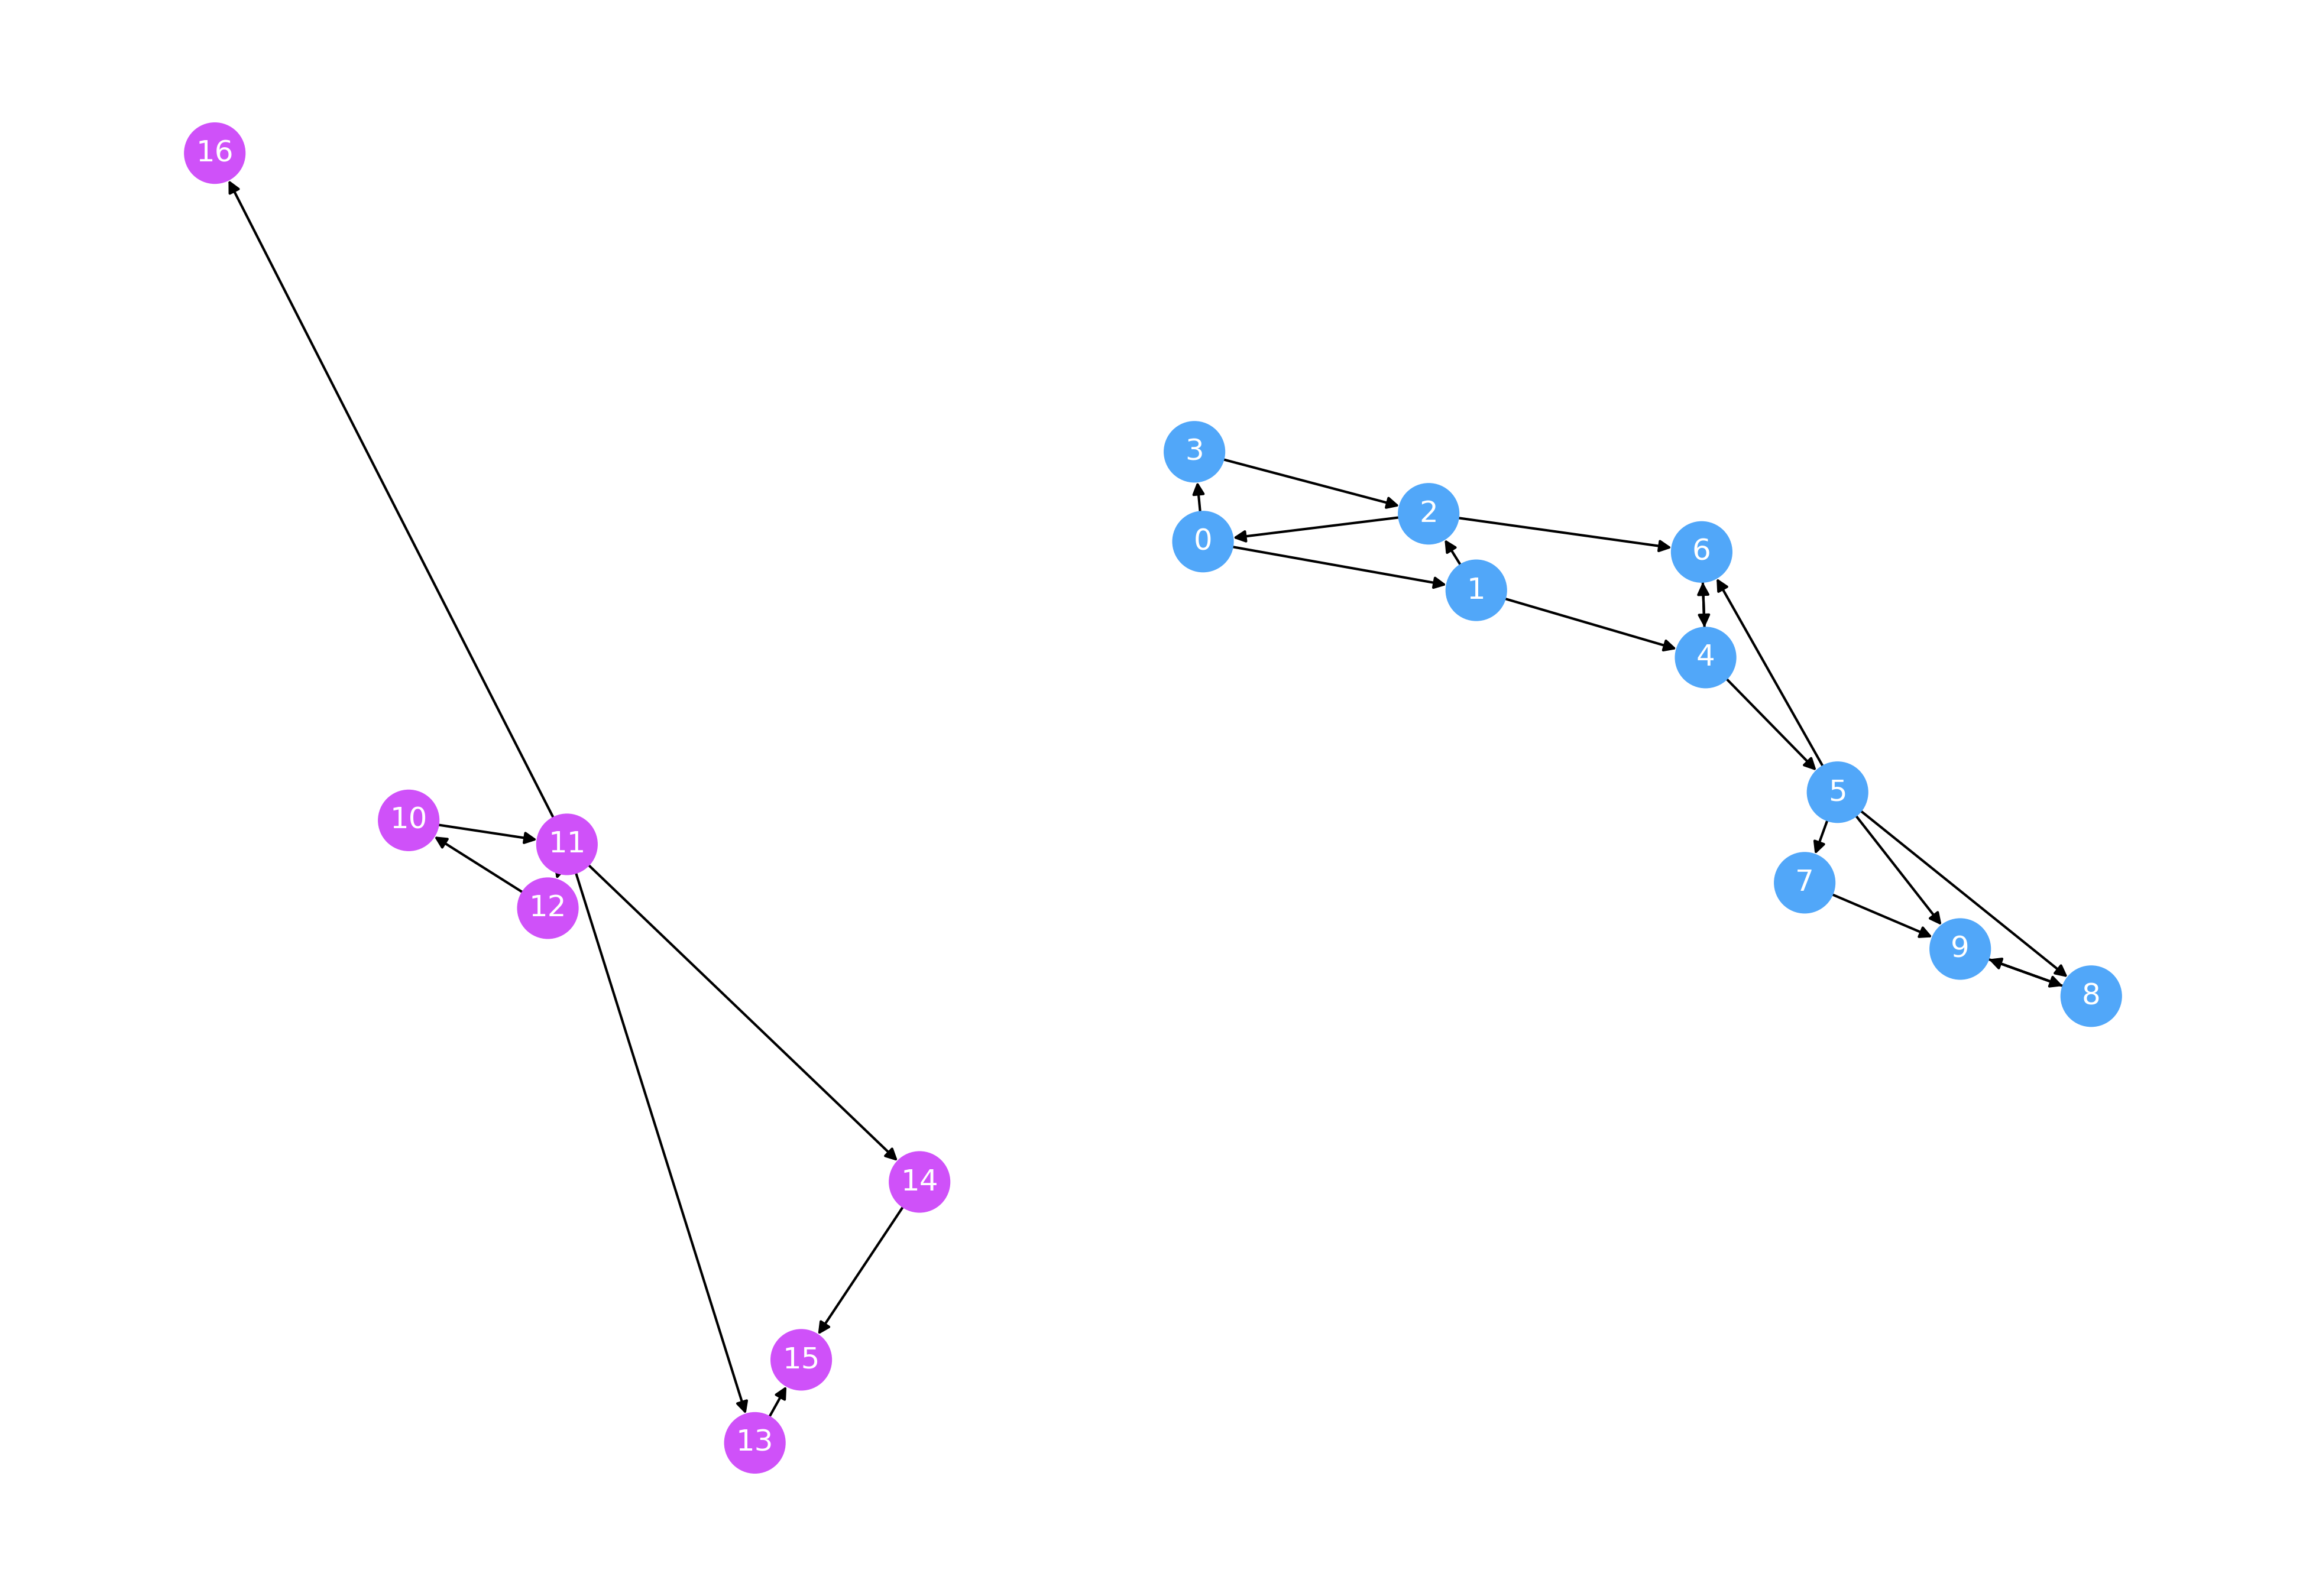

In [8]:
node_colors = [colors[0] if node in WCC[0] else colors[1] for node in G_test.nodes]

nx.draw(G_test, pos=G_pos, node_size=600, node_color=node_colors)
nx.draw_networkx_labels(G_test, pos=G_pos, font_color='white');

# Strongly Connected Components

In [9]:
SCC_test = list(nx.strongly_connected_components(G_test))

Now we find that our test network has 9 strongly connected compoenents that subdivide each of our previously found WCC.

In [10]:
SCC_test

[{8, 9}, {7}, {4, 5, 6}, {0, 1, 2, 3}, {15}, {13}, {14}, {16}, {10, 11, 12}]

A quick visualization makes this clear

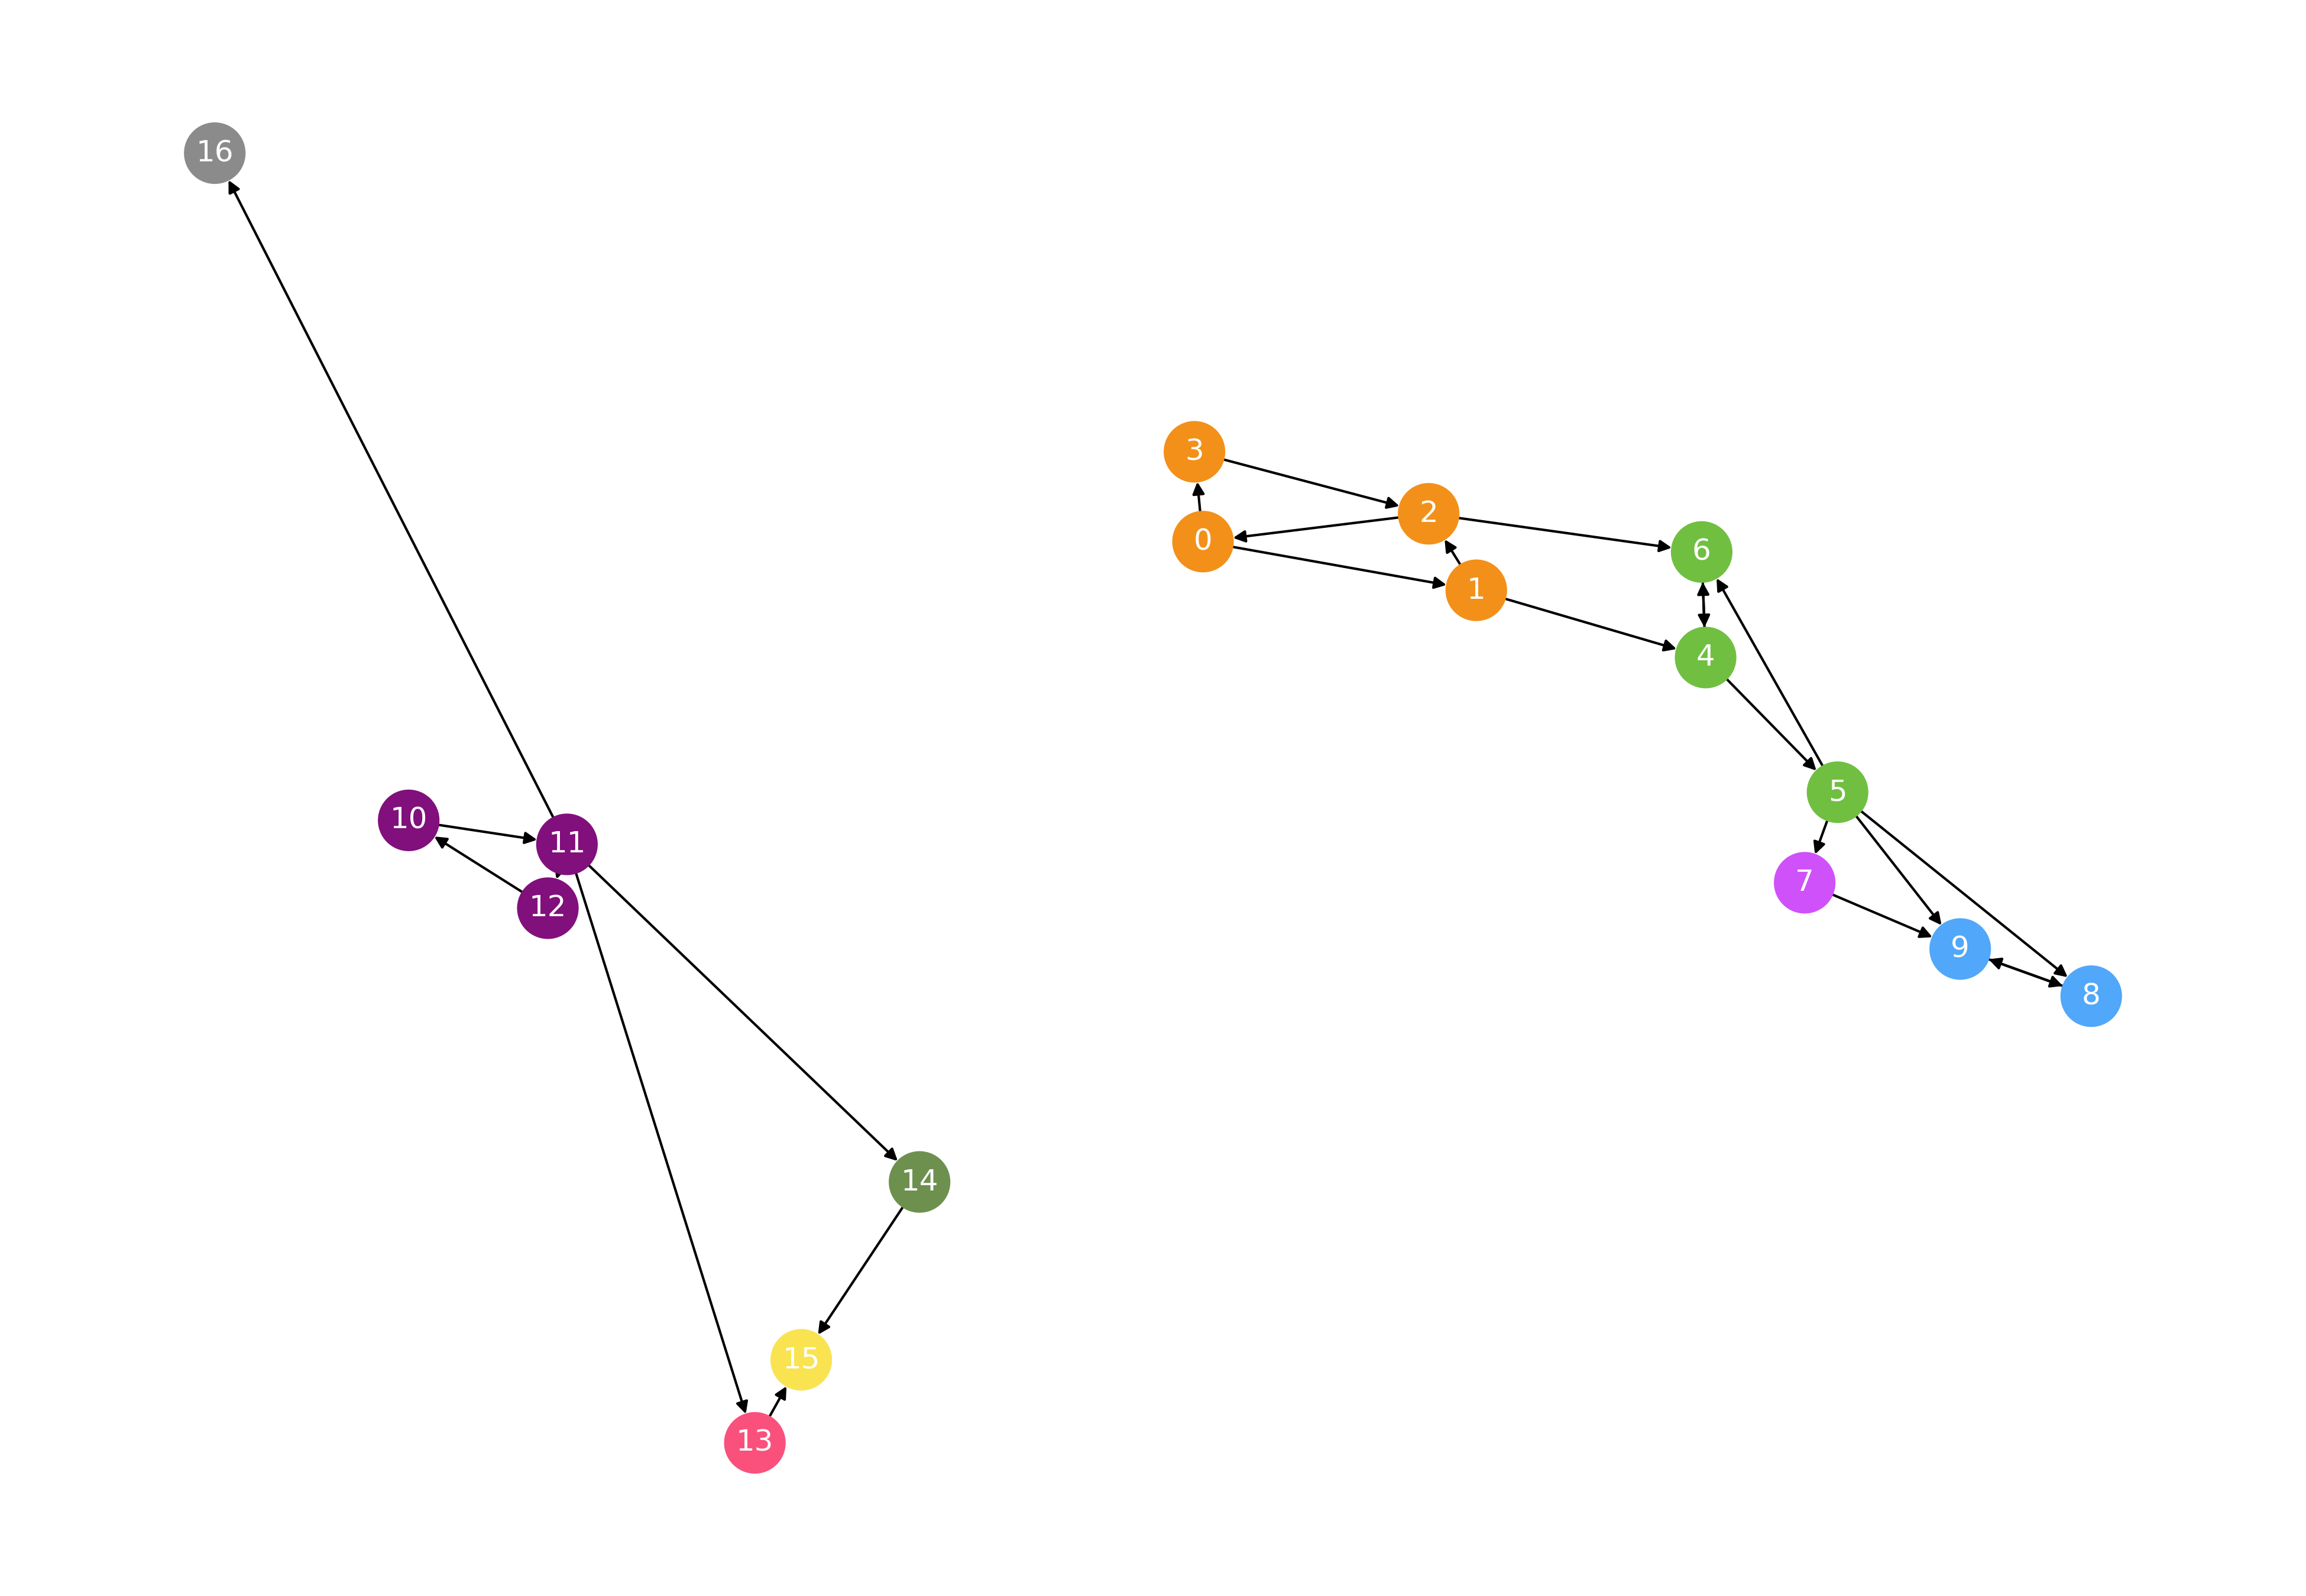

In [11]:
node_colors = []

for node in G_test.nodes:
    for i, comp in enumerate(SCC_test):
        if node in comp:
            node_colors.append(colors[i])
            
nx.draw(G_test, pos=G_pos, node_size=600, node_color=node_colors)
nx.draw_networkx_labels(G_test, pos=G_pos, font_color='white');

# Load transaction inputs and outputs

Each transaction can have an arbitrary number of inputs and outputs. The inputs for one transaction are the numered outputs of another, with the outputs are wallet addresses. Out dataset makes our lives a bit easier by mapping the transaction inputs to individual addresses as well.

In [12]:
txin = pd.read_csv('data/txin.txt.gz', sep=' ', header=None, 
                names=['txid', 'addrID_in', 'value_in'], 
                   dtype={'value_in': 'int64', 'addrID_in': 'str',
                          'txid': 'str'}
                  ).sort_values('txid')
txout = pd.read_csv('data/txout.txt.gz', sep=' ', header=None, 
                names=['txid', 'addrID_out', 'value_out'], 
                   dtype={'value_out': 'int64', 'addrID_out': 'str',
                          'txid': 'str'}
                   ).sort_values('txid')

Save the images of the dataframes

In [13]:
txin.head()

,txid,addrID_in,value_in
811449,101107045,26975401,1949990000
1942625,101107046,64015289,12500000
1754780,101107047,57756609,2900000
1337226,101107048,43773546,5800000
1263425,101107049,41410645,9457394


In [14]:
txout.head()

,txid,addrID_out,value_out
2917664,101107044,92941637,2522206709
438287,101107045,14482566,160772600
1574551,101107045,50151625,1788817400
2832733,101107046,90097048,12400000
54546,101107047,1867036,2800000


We also create a dict of Transaction IDs to hashs:

In [15]:
trans_dict = dict(pd.read_csv('data/txhash.txt.gz', sep=' ', header=None, 
                              names=['txid', 'txhash'], dtype='str').values)

Since we're mapping to addresses, we compute the total values by input/output. These will come in handy later

In [18]:
total_in = txin[['txid', 'value_in']].groupby(['txid']).sum()
total_out = txout[['txid', 'value_out']].groupby(['txid']).sum()

Now we match input and output values

In [19]:
totals = total_in.join(total_out, how='inner')

The fee paid by a transaction is the difference between the input and output values

In [21]:
totals['fee'] = totals['value_in'] - totals['value_out']

And can be fairly large

In [25]:
totals.sort_values('fee', ascending=False).head()

,value_in,value_out,fee
txid,,,
102275040,4800091956,4720271956,79820000
101763142,735605245,695605245,40000000
101762081,483589254,463589254,20000000
102149798,476206572,456206572,20000000
101820675,249069179,233069179,16000000


Now we join the inputs and outputs for each transaction

In [28]:
trans = txin.merge(txout, on='txid').set_index('txid')

In [29]:
trans.head()

,addrID_in,value_in,addrID_out,value_out
txid,,,,
101107045,26975401,1949990000,14482566,160772600
101107045,26975401,1949990000,50151625,1788817400
101107046,64015289,12500000,90097048,12400000
101107047,57756609,2900000,1867036,2800000
101107048,43773546,5800000,46562047,5700000


We have over 14 million rows in our full dataframe

In [30]:
trans.shape

(14181316, 4)

Let's look at a specific transaction

In [31]:
trans_ex = trans.loc['101240012'].sort_values('value_out')

Here we have 8 inputs and 1 output, so it's pretty clear we get 8 edges

In [32]:
trans_ex

,addrID_in,value_in,addrID_out,value_out
txid,,,,
101240012,92973567,666222,100727977,7043791
101240012,82605258,1375212,100727977,7043791
101240012,85111997,162710,100727977,7043791
101240012,82605258,1390000,100727977,7043791
101240012,83358190,1315405,100727977,7043791
101240012,417,477380,100727977,7043791
101240012,8122206,904655,100727977,7043791
101240012,58313199,812207,100727977,7043791


We can also look up this transaction online. The hash of the transaction is:

In [33]:
trans_dict['101240012'].lower()

'cbd79d3e8dffb3f41afb69e77a4e4b6122d125387a42674de4c941c3e74c0363'

Which we can easily find online

[![alt text](data/blockchain.png "Block")](https://www.blockchain.com/btc/tx/CBD79D3E8DFFB3F41AFB69E77A4E4B6122D125387A42674DE4C941C3E74C0363)

Let's consider another example

In [34]:
trans_ex2 = trans.loc['101107060'].sort_values('value_out')

Here we have 2 inputs and 2 outputs, so we get 4 edges

In [35]:
trans_ex2

,addrID_in,value_in,addrID_out,value_out
txid,,,,
101107060,58700630,523000,3203331,1000615
101107060,67593721,15277615,3203331,1000615
101107060,58700630,523000,110812190,14700000
101107060,67593721,15277615,110812190,14700000


But since the value_in/value_out are just repeated how do we ajust them to specify how much, say, addrID_in 58700630 sends to addID_out 3203331? Each transaction works as a mixer so we just divide them evenly

In [36]:
trans_ex2['value_in'] = (trans_ex2['value_in']/total_in.loc['101107060'].sum()*trans_ex2['value_out'])

And we can easily check that the weights sum up to the total output value

In [37]:
trans_ex2['value_in'].sum()

15700615.0

And comparing

In [38]:
total_out.loc['101107060']

value_out    15700615
Name: 101107060, dtype: int64

So we finally recover the edges of our address network for this transaction

In [39]:
trans_ex[['addrID_in', 'addrID_out', 'value_in']]

,addrID_in,addrID_out,value_in
txid,,,
101240012,92973567,100727977,666222
101240012,82605258,100727977,1375212
101240012,85111997,100727977,162710
101240012,82605258,100727977,1390000
101240012,83358190,100727977,1315405
101240012,417,100727977,477380
101240012,8122206,100727977,904655
101240012,58313199,100727977,812207


so we apply this transformation to all transactions in our dataset. This takes a while, so we cache the result

In [40]:
if not os.path.exists('data/transaction_edges.txt.gz'):
    def extract_edges(tx):
        txid = tx['txid'].iloc[0]

        tx['value_in'] = (tx['value_in']/total_in.loc[txid].sum()*tx['value_out'])
        return tx[['txid', 'addrID_in', 'addrID_out', 'value_in']]    
    
    trans_edges = trans.reset_index().groupby('txid').progress_apply(extract_edges)
    trans_edges.to_csv('data/transaction_edges.txt.gz', header=True, index=False)
else:
    trans_edges = pd.read_csv('data/transaction_edges.txt.gz')

And now we have a total of over 10 million edges

In [41]:
edges = trans_edges[
    ['addrID_in', 'addrID_out', 'value_in']
].groupby(['addrID_in', 'addrID_out'], as_index=False).sum()

In [42]:
edges.shape

(10314275, 3)

Connecting over 2.5 million individual addresses

In [43]:
len(set(edges.addrID_in) | set(edges.addrID_out))

2505841

# Wallets

One aspect of the transactions that not imediately appearent is that, while inputs can come from multiple addresses, the person performing the transaction must posess the private keys for each of them. In practice, this means that the addresses that share a common transaction all belong to the same person and can be grouped into wallets idendifying individual entities.

We start by generating edges connecting all the addresses that are inputs to the same transaction. In this way we create a graph where each weakly connected component contains all the addresses controled by a single individual (or institution).

In [44]:
edges = set()
txid = None

for row in tqdm(txin.itertuples(index=False), total=txin.shape[0]):
    if row.txid == txid:
        edges.add((row.addrID_in, oldAddr))
        
    oldAddr = row.addrID_in
    txid = row.txid

  0%|          | 0/4059646 [00:00<?, ?it/s]

In total we have just over 1.9M unique edges connecting addresses

In [45]:
G = nx.DiGraph()
G.add_edges_from(edges)

Now we use the same function we defined previously to identify each of the connected components

In [46]:
components = list(nx.weakly_connected_components(G))

resulting in 382k components

In [47]:
len(components)

382681

We can easily compute the size of each component

In [48]:
comp_sizes = [len(comp) for comp in components]

In total we have 1.6M individual addresses assigned to clusters. This is a subset of the total number of addresses in our dataset as we are not counting "unspent transaction outputs", outputs from transactions that haven't been spent yet

In [49]:
sum(comp_sizes)

1648014

And we can also compute the distribution of component sizes

In [50]:
Ns = Counter(comp_sizes)
Ns = pd.DataFrame(sorted(Ns.items(), key=lambda x: x[0]), columns=['s', 'Ns'])

Which we can plot on a logarithmic scale

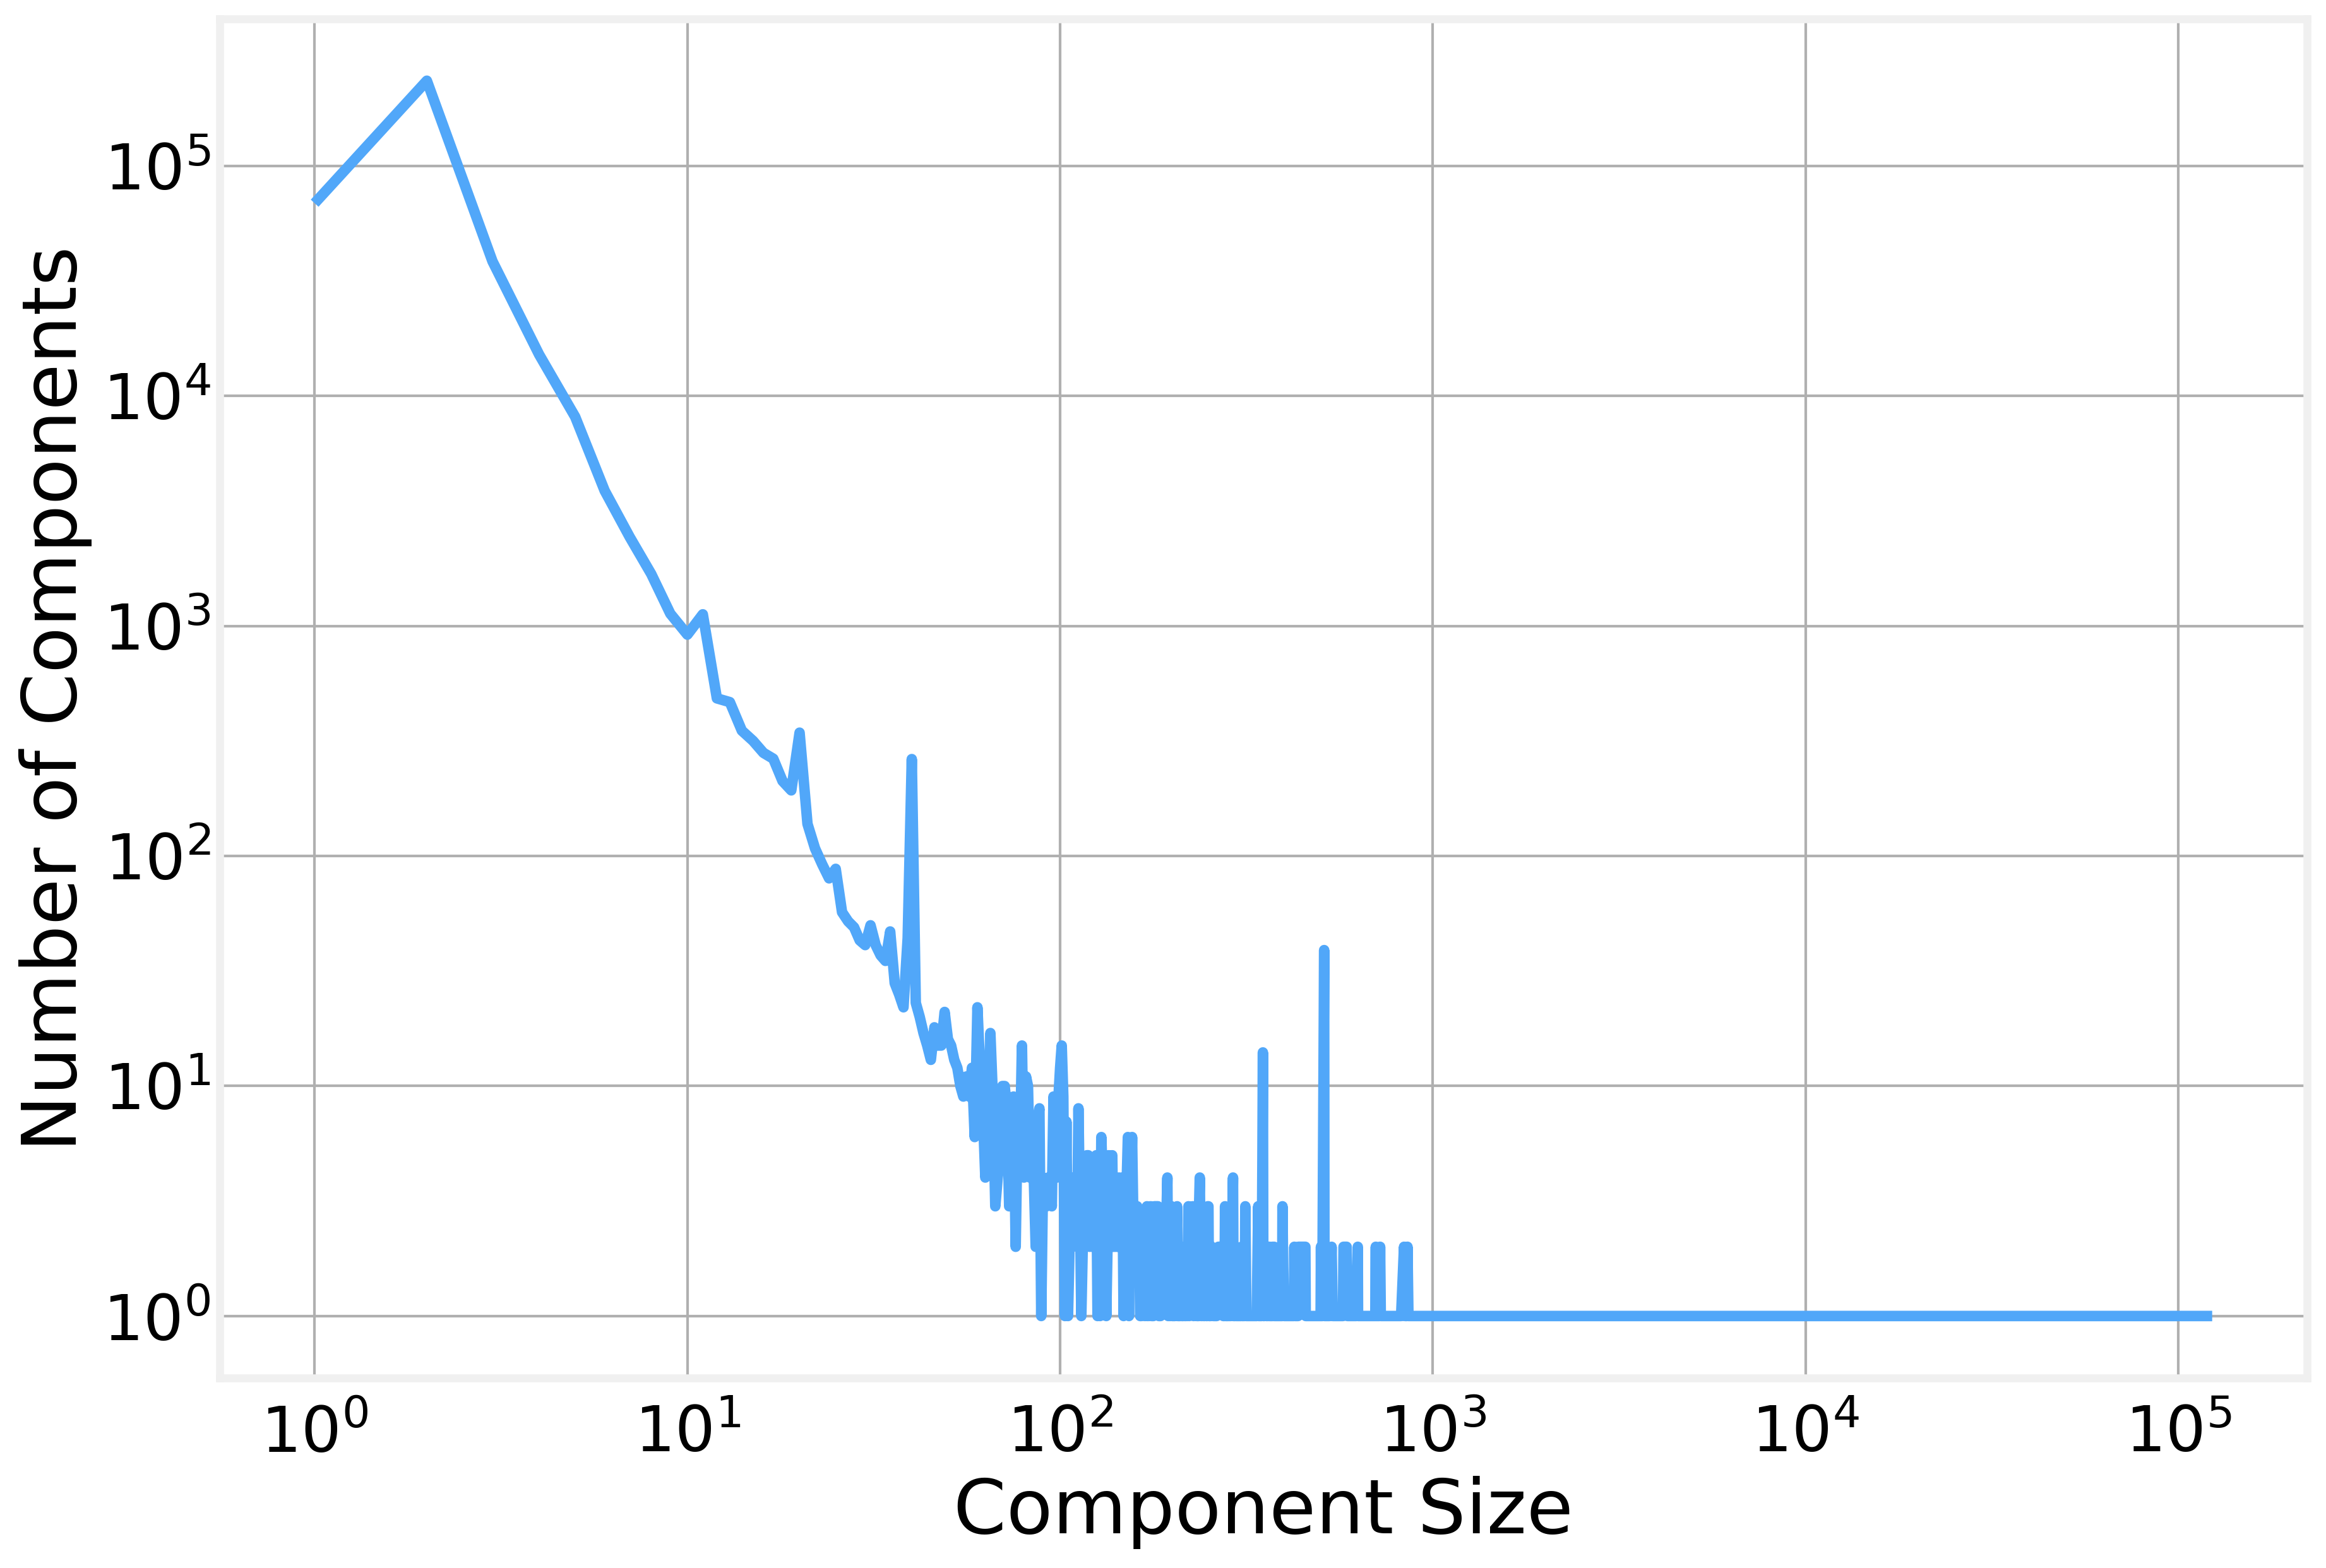

In [51]:
ax = Ns.plot(x='s', y='Ns', legend=None)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number of Components')
ax.set_xlabel('Component Size')
ax.tick_params(axis='x', which='major', pad=10)

The largest components accounts for an astonishing 123,285 addresses, almost 10x as many as the second largest component

In [52]:
Ns.tail()

,s,Ns
512,9640,1
513,14684,1
514,15014,1
515,18769,1
516,123285,1


While 50% of the addresses belong to clusters of size 10 or smaller

In [53]:
Ns['Naddresses'] = np.cumsum(Ns.s*Ns.Ns)
Ns['Naddresses']/=Ns['Naddresses'].max()

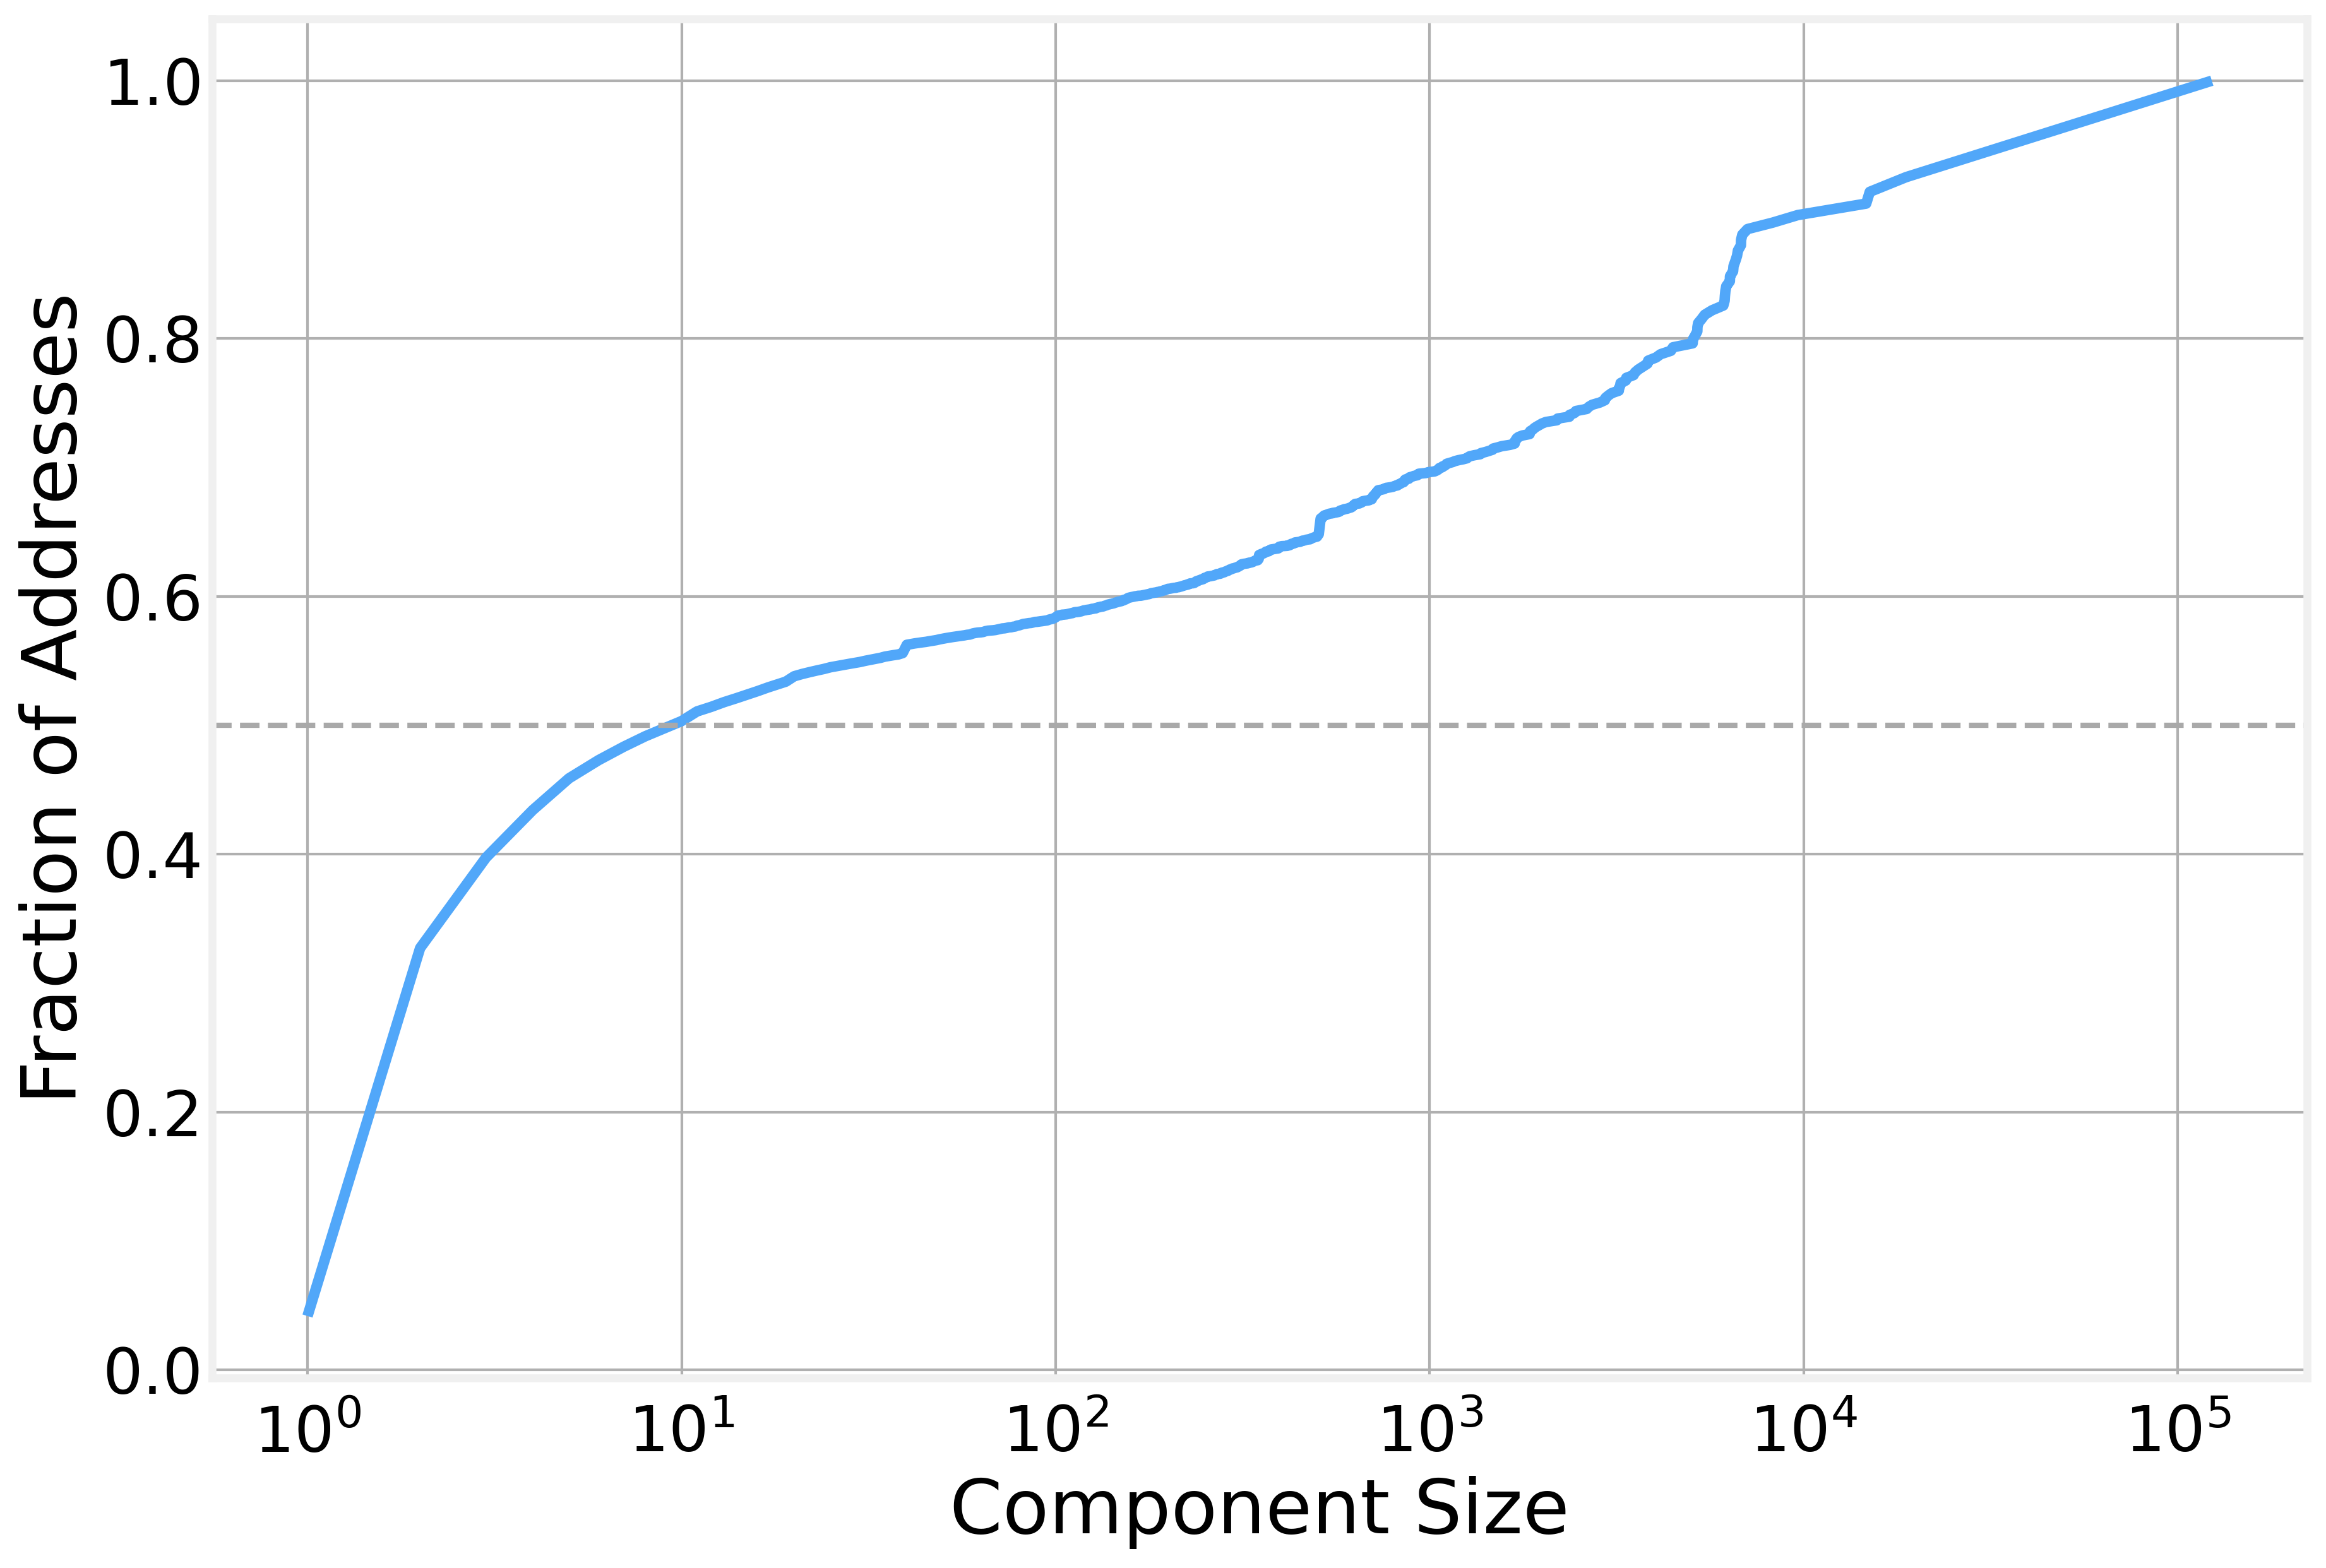

In [54]:
ax = Ns.plot(x='s', y='Naddresses', legend=None)
ax.set_ylabel('Fraction of Addresses')
ax.set_xlabel('Component Size')
ax.set_xscale('log')
ax.axhline(y=0.5, lw=2, linestyle='--', color='darkgray')
ax.tick_params(axis='x', which='major', pad=10)

Finally, we extract the largest connected component

In [ ]:
largest_component = np.argmax(comp_sizes)
GCC = nx.subgraph(G, components[largest_component])

# Motifs

## Toy Graph

Let us define the example graph as defined [here](https://ieeexplore.ieee.org/abstract/document/4015377)

In [50]:
G = nx.Graph()
G.add_edges_from(
[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 6),
 (2, 7),
 (3, 8),
 (3, 9),
])

In [51]:
pos = {
    1: (1, 1),
    2: (3, 1),
    3: (2, 2),
    4: (0, 1),
    5: (0, 0),
    6: (4, 0),
    7: (4, 1),
    8: (1, 3),
    9: (3, 3),   
}

We can now plot it

(-0.5, 3.5)

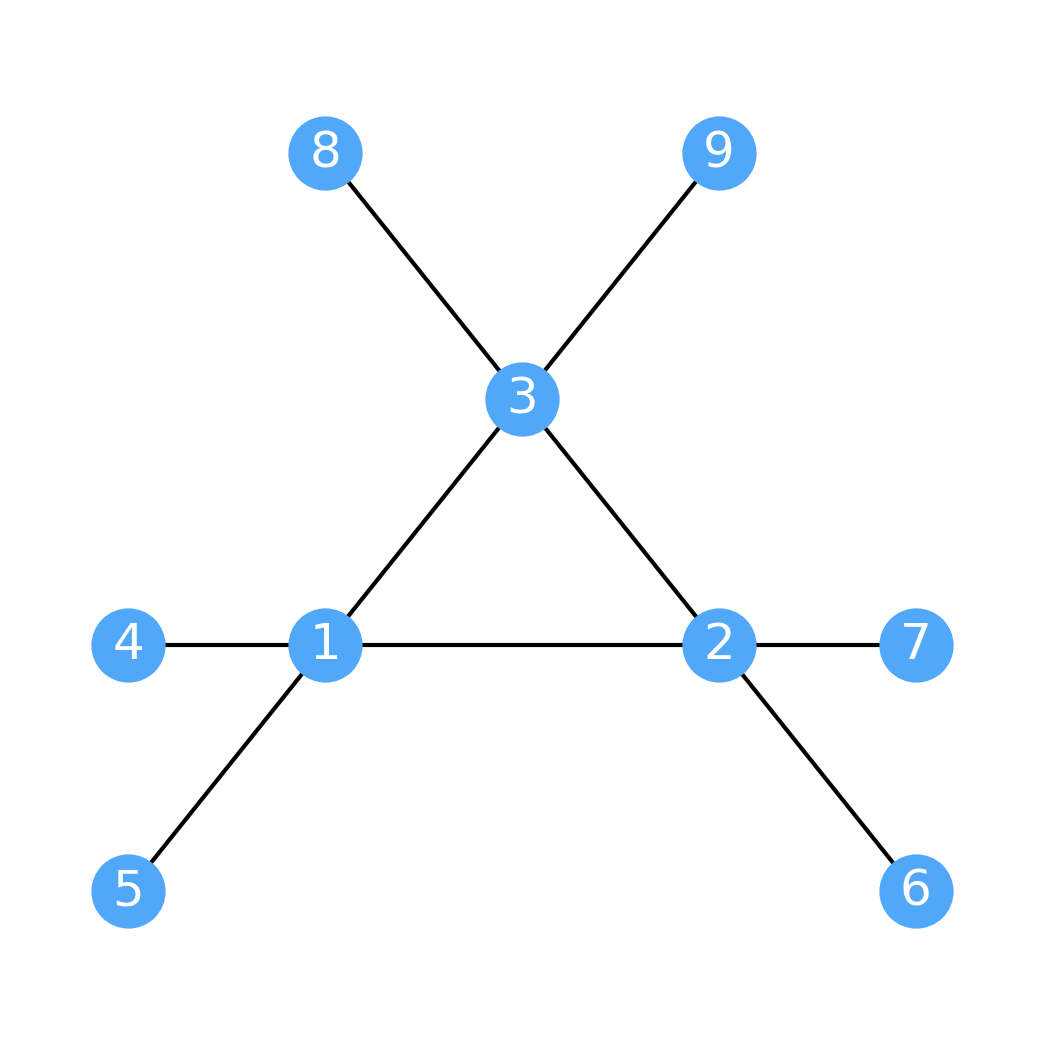

In [52]:
fig, ax = plt.subplots(1, figsize=(4,4))
nx.draw(G, pos=pos, node_color=colors[0], ax=ax)
nx.draw_networkx_labels(G, pos=pos, font_color='white', ax=ax)
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, 3.5)

We start by defining an open neighbourhood as being all nodes that a set of nodes is connected to, other than themselves

In [53]:
def OpenNeighborhood(nodes, G):
    if type(nodes) == type(1) or type(nodes) == type('1'):
        nodes = set([nodes])
        
    neighborhood = set()

    for node in nodes:
        NN = set(G.neighbors(node))
        neighborhood.update(NN)

    return neighborhood - set(nodes)

So the open neighborhood of nodes {1, 3} is {3, 4, 5, 6, 7}

In [54]:
OpenNeighborhood({1, 2}, G)

{3, 4, 5, 6, 7}

We also introduce the concept of an exclusive neighborhood of a node with respect to a set of nodes V as being the nodes that it is connected to except those in V or their neighbors

In [55]:
def ExclusiveNeighborhood(node_v, nodes, G):
    neighborhood = set()
    
    for node in nodes:
        NN = set(G.neighbors(node))
        neighborhood.update(NN)
    
    NN = set(G.neighbors(node_v))
    
    return NN-neighborhood

So the exclusive neighborhood of 1 wrt to 6 and 2 is

In [56]:
ExclusiveNeighborhood(1, {6, 2}, G)

{4, 5}

As we must exclude 2 and it's neighbor 3

Finally, we are able to implement the ESU algorithm as defined in Fig3

In [57]:
def EnumerateSubgraphs(G, k):
    graphs = []
    
    for v in G.nodes:
        Vext = {u for u in OpenNeighborhood(v, G) if u > v}
        graph = ExtendSubgraph({v}, Vext, v, k, G)
        
        if len(graph) > 0:
            graphs.extend(graph)
        
    return graphs

def ExtendSubgraph(Vsub, Vext, v, k, G):
    if len(Vsub) == k:
        return [nx.subgraph(G, Vsub)]
    
    graphs = []
    
    while len(Vext) != 0:
        w = Vext.pop()
        Vext2 = Vext | {u for u in ExclusiveNeighborhood(w, Vsub, G) if u > v}
        graph = ExtendSubgraph(Vsub | {w}, Vext2, v, k, G)
        
        if len(graph) > 0:
            graphs.extend(graph)
        
    return graphs

Applying this algorithm to our toy graph we obtain the 16 subgraphs enumerated in Fig4

In [58]:
graphs = EnumerateSubgraphs(G, 3)

Which we plot for ease of reference

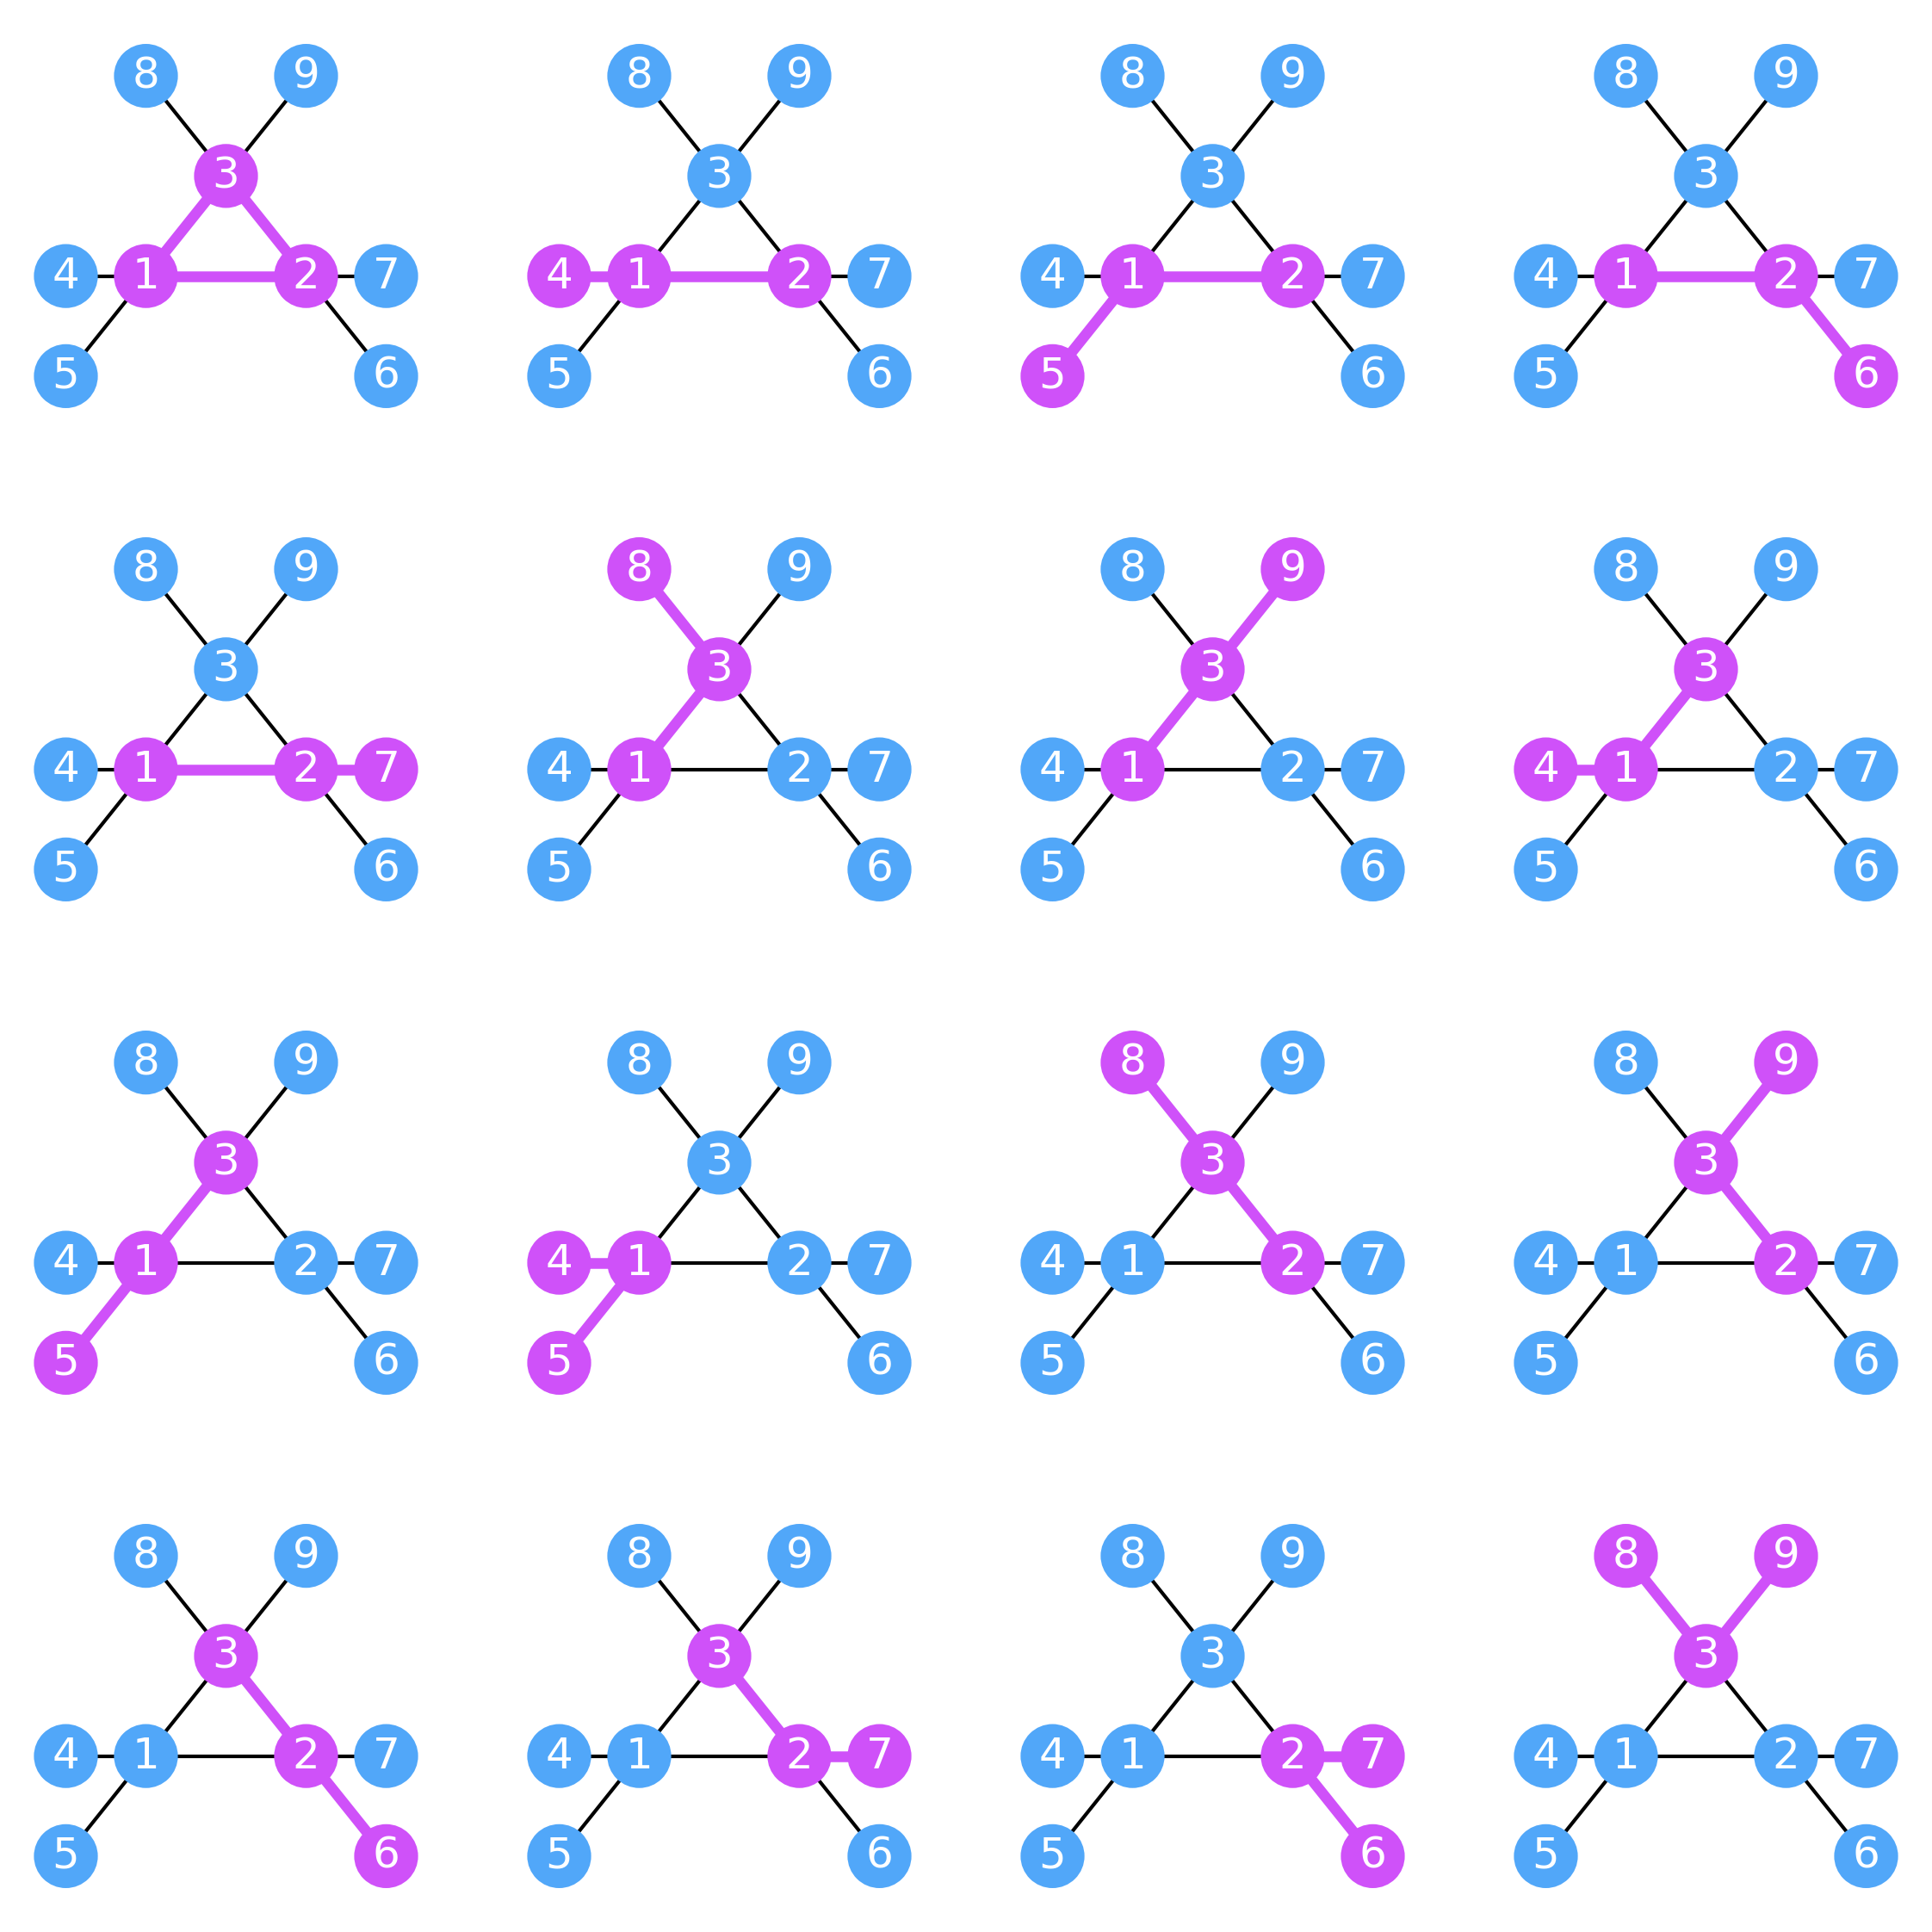

In [59]:
fig, ax_lst = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 8))
ax_lst = np.array(ax_lst).flatten()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, graph in enumerate(graphs):
    node_color = [colors[0] if node not in graph.nodes() else colors[1] for node in G.nodes()]
    
    nx.draw(G, pos=pos, ax=ax_lst[i], node_color=node_color)
    nx.draw_networkx_labels(G, pos=pos, ax=ax_lst[i], font_color='white')
    nx.draw_networkx_edges(graph, pos=pos, ax=ax_lst[i], edge_color=colors[1], width=3)

    ax_lst[i].set_ylim(-0.5, 3.5)
    ax_lst[i].set_xlim(-0.5, 4.5)
    
fig.tight_layout()

Finally, we introduce a simple function to count the popularity of each motif. This function simply enumerates all the unique isomorphic subgraphs (graphs that differ only by the labels of the nodes) 

In [60]:
def CountMotifs(graphs):
    counts = {}

    for graph in graphs:
        if len(counts) == 0:
            counts[graph] = 1
        else:
            match = False

            for g in counts:
                if nx.is_isomorphic(graph, g):
                    counts[g] += 1
                    match = True
                    break

            if not match:
                counts[graph] = 1
                
    return counts

In our set 16 subgraphs, we see that there are only two motifs, one with 3 edges (a triangle) that appears only once and one with 2 edges that accounts for the remaining 15 subgraphs

In [61]:
counts = CountMotifs(graphs)
counts

{<networkx.classes.graph.Graph at 0x7f9f152d0250>: 1,
 <networkx.classes.graph.Graph at 0x7f9f1533a2b0>: 15}

Which we plot side by side

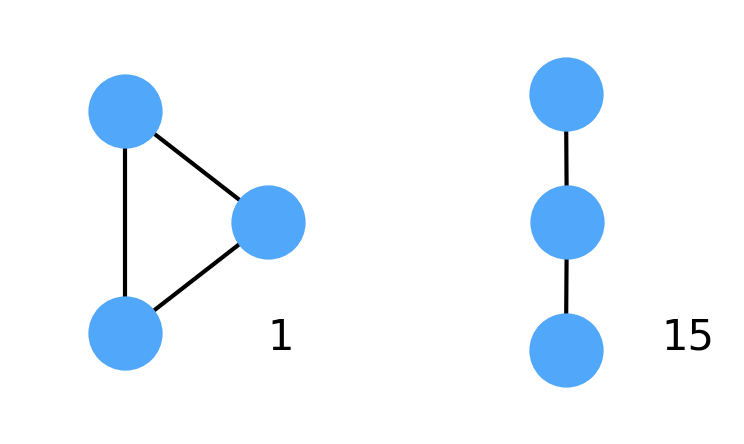

In [62]:
fig, ax_lst = plt.subplots(1, 2, figsize=(3, 2))
ax_lst = np.array(ax_lst).flatten()

for i, g in enumerate(counts.keys()):
    gpos = nx.layout.kamada_kawai_layout(g)
    gpos = nx.layout.rescale_layout_dict(gpos)
    nx.draw(g, ax=ax_lst[i], pos=gpos, node_color=colors[0])

    ax_lst[i].set_ylim(-1.5, 1.5)
    ax_lst[i].set_xlim(-1.5, 1.5) 
    
    ax_lst[i].text(1, -1, counts[g], fontsize=10)

for i in range(len(counts), len(ax_lst)):
    ax_lst[i].axis('off')

Where the number next to each motif corresponds to the frequency with which it occurs

Now we enumerate all subgraphs with 3 nodes

In [63]:
graphs = EnumerateSubgraphs(GCC, 3)

There's over 56000 of them!

In [64]:
len(graphs)

56286

Which can be neatly grouped into just 62 motifs

In [65]:
counts = sorted(list(CountMotifs(graphs).items()), key=lambda x:x[1], reverse=True)

In [66]:
len(counts)

62

Which we can easily visualize. 

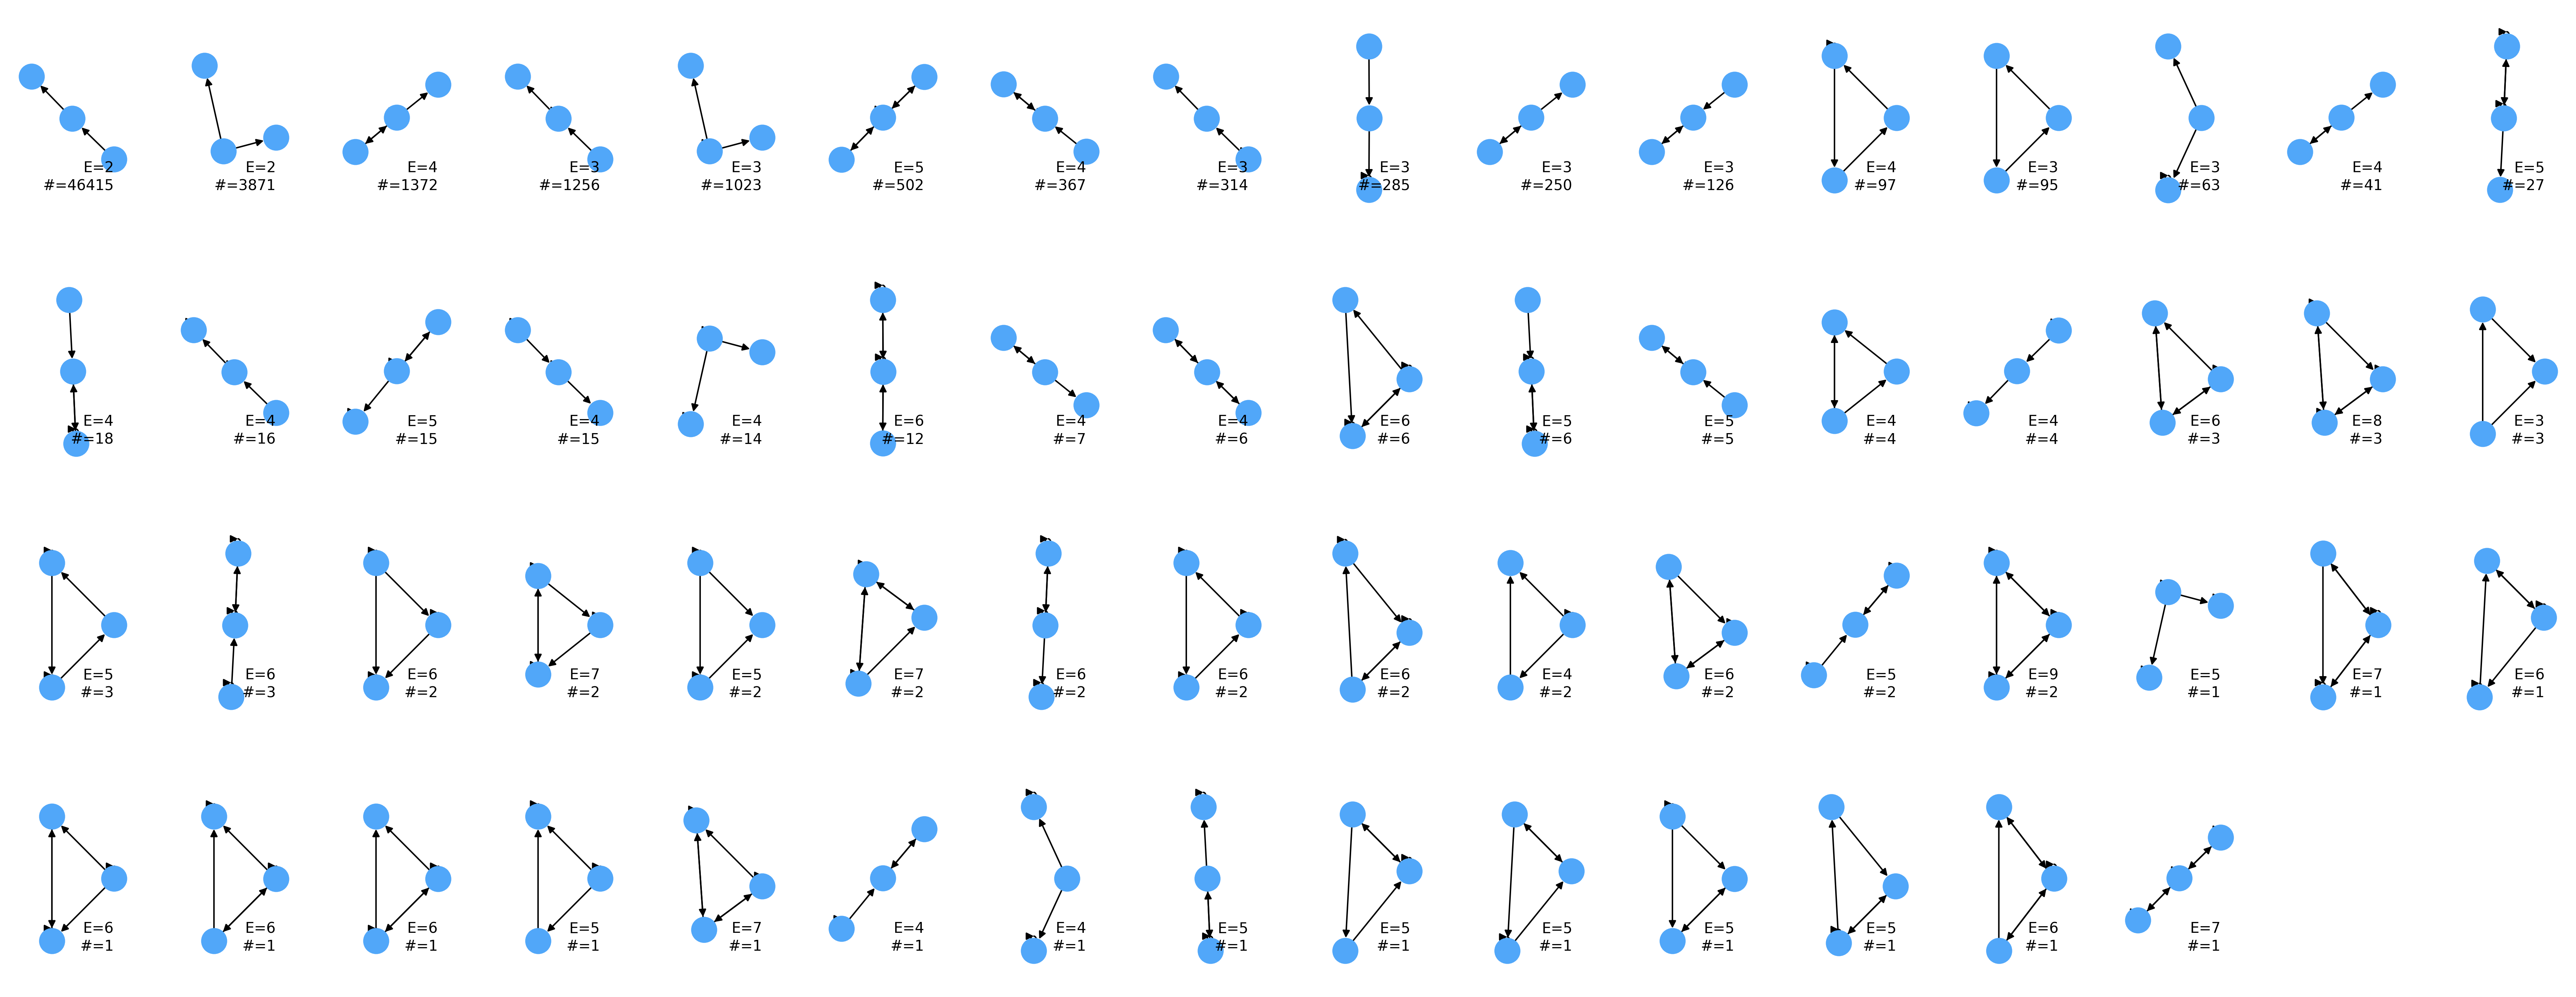

In [67]:
fig, ax_lst = plt.subplots(4, 16, figsize=(25, 10))
ax_lst = np.array(ax_lst).flatten()

for i, (g, count) in enumerate(counts):
    pos = nx.layout.kamada_kawai_layout(g)
    pos = nx.layout.rescale_layout_dict(pos)
    nx.draw(g, ax=ax_lst[i], pos=pos, node_color=colors[0])
    
    ax_lst[i].set_ylim(-1.5, 1.5)
    ax_lst[i].set_xlim(-1.5, 1.5) 
    
    ax_lst[i].text(1, -1, "#=%u" % count, fontsize=10, ha='right')
    ax_lst[i].text(1, -.75, "E=%u" % g.number_of_edges(), fontsize=10, ha='right')

    
for i in range(len(counts), len(ax_lst)):
    ax_lst[i].axis('off')

Here the numbers are increased significantly iv, since we allow for self edges as well as directed edges

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>